# Machine-Learning-and-Statistics-Project 2020

***

##  Project 2020


In this project you must create a web service that uses machine learning to make predictions
based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed
values, as in the data set. You must then develop a web service that will respond with
predicted power values based on speed values sent as HTTP requests. Your submission
must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you
should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.
To enhance your submission, you might consider developing and comparing more than
one model. 

## Introduction

The general goal of machine learning is to build models that can learn from data without being explicitly programmed. Supervised learning refers to the fact that each sample within the data being used to build the system contains an associated label. The goal is to build a model that can accurately predict the value of the label when presented with new data. The supervised learning model takes the form:

Y=f(x)
   
Where the label is assumed to be some general function of the input features. 

Power curve of a wind turbine depicts the relationship between output power and wind speed.  Accurate models of power curves can play an important role in improving the performance of wind energy based systems. This notebook presents a detailed review of different approaches for modelling the wind turbine power curve. [1]



#### Task objectives:
- Research the Power production dataset.
- Explore models
- Determine model to use
- Develop web service

### Choosing an Appropriate Model
Choosing an appropriate model depends on a number of factors, including:

- The size of the data, as some models perform better on larger or smaller data sets

- The distribution of the data, as some models assume the features with a dataset follow a specific statistical distribution

- The relationship between the features and labels (linear or non-linear, additive or multiplicative, etc.)

#### Explore the dataset

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tensorflow.keras as kr
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
# Make matplotlib show interactive plots in the notebook.
%matplotlib inline
# Apply the default seaborn settings
sns.set()

In [3]:
# Import the power production dataset and call it pp
pp = pd.read_csv("powerprod.csv")
print(pp.head())

   speed  power
0  0.000    0.0
1  0.125    0.0
2  0.150    0.0
3  0.225    0.0
4  0.275    0.0


In [4]:
pp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,500.0,12.590398,7.224991,0.0,6.32475,12.5505,18.77525,25.000
power,500.0,48.014584,41.614572,0.0,5.28800,41.6455,93.53700,113.556


Note that many of the features have different scales. This is important to recognize because many machine learning models are sensitive to the relative scaling of each feature, and it is often necessary to rescale the features to the same range. The most common ways to do this are to normalize each feature so that it ranges from 0 to 1, or standardize each feature so that it has zero mean and a standard deviation of one. For our example, the final result will be the same whether we scale or not, but it will make the coefficients more interpretable if we do.

In [5]:
pp.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


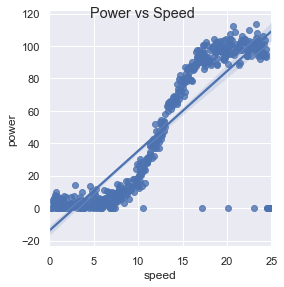

In [6]:
p = sns.pairplot(data=pp,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

<AxesSubplot:xlabel='speed', ylabel='power'>

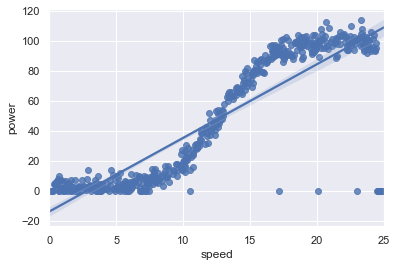

In [7]:
sns.regplot(x="speed", y="power", data=pp)

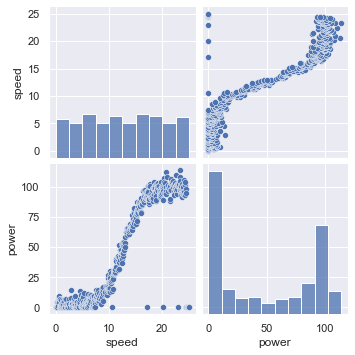

In [8]:
sns.pairplot(pp)

Observations

Not obvious what model it fits 
- Below approximately 10, power is not generated
- Between 10 & 90 this is a linear correlation
- From 90 upwards power has returned constant values
- there is 0 power generated at certain points - are these outliers and should they be excluded?  


In practice, however, wind turbines are never used under ideal conditions, and the empirical power curves could be substantially different from the theoretical ones due to the location of the turbine, air density, wind velocity distribution, wind direction, mechanical and control issues, as well as uncertainties in measurements.[2]

<AxesSubplot:xlabel='speed', ylabel='power'>

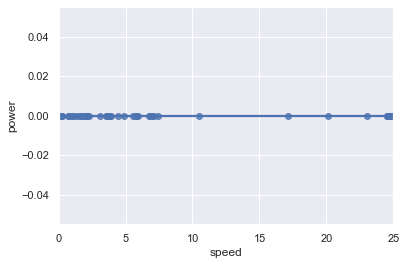

In [9]:
j = pp[pp.power == 0]
sns.regplot(x="speed", y="power", data=j)

 Do we exclude - is it noise or bias?
 https://stats.stackexchange.com/questions/324813/is-neural-network-able-to-learn-from-zero-inputs

Will include zeros for moment as part of the dataset with a view to incorporate into the model.
In his "Deep learning with Python" book, Francois Chollet says that "With neural networks, it's safe to input missing values as 0, with the condition that 0 isn't already a meaningful value. The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value."
Q1. Why Chollet says that the network will learn to ignore the value? I think it is not necessary to learn; the network will ignore values 0 without learning!

Q2. Why he says that "with the condition that 0 isn't already a meaningful value. As I said, the value 0 cannot carry any meaning, because it has not any effect in the network.

### Linear Regression Model

Our goal is to predict power output from a given wind speed. If we have a label Y" and features X1" through Xp", the linear regression model is of the form:

$$ Y=β0+β1X1+β2X2+ ... +βpXp" $$
  

Here, the β" terms are unknown coefficients that will be determined by the data set. A linear regression model assumes a linear relationship between the label and the coefficients"  of the features. However, it is perfectly acceptable, and often helpful, to use non-linear features such as X1X2" or X12", if it improves the model. The resulting model is still linear, and all of the general rules regarding linear regression models apply.

Before we import our data, there are two questions we need to address.  How are the Β's determined?
The coefficients selected are those that minimize a quantity known as the residual" sum of" squares, or RSS. If we denote a true label as Y, a predicted label as Y^", and have a total of n samples, the RSS is defined as
$$ \sum \limits_{i=1}^{n} (y_i-f(x_i))^2 $$


The minimum RSS is achieved when the values between the true and predicted labels are as small as possible. The selected β values will be those that achieve the smallest delta between the true and predicted labels.

How do we measure the accuracy of our model?
The root mean squared error (RMSE), which is given by the equation 

 
 
$$\mathrm{RMSD} = \sqrt{\frac{\sum_{i=1}^{N}\left(x_{i}-\hat{x}_{i}\right)^{2}}{N}}$$

The RMSE can be thought of the as the square root of the 'average' RSS for each term. One advantage of using RMSE is that it is in the same units as the label. As with RSS, smaller values are better, but there isn't a cutoff for what's considered a 'good' value. Such a threshold depends on the specifics of the problem.

#### Training Data Versus Test Data
Split the data set into two groups, one for training our model, and one for testing it. It's important to set aside some data for testing because we need to get a sense of how our model will perform on data it has never seen before, which is what it would do if it were used in a real production environment. Because our model has already seen the training data, it would not be a good idea to predict prices using that same data. We would expect the model to perform well, and that would give us an over-optimistic estimate of our model's performance ability. The real test is to use data that is new, and that's the purpose of keeping a separate set of data specifically for testing. We want to keep our test data pristine, so we'll split it away from the training data before we do any scaling.

 
The first thing to do is split the data back apart into features (X) and labels (y). Then, we can use the 'train_test_split' function from scikit-learn to randomly split our data into training and testing sets. Note that this split should always be random, in case the data is ordered in some way. A common split is to allocate 70-80% for training, and the rest for testing. Also, because the split is random, we are highly likely to generate training and testing sets that both capture the same underlying relationship between the features and labels.

In [10]:
X = pp.iloc[:,:-1]
y = pp['power']

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing. 
# The random_state allows us to make the same random split every time.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=327)

print('Training data size: (%i,%i)' % X_train.shape)
print('Testing data size: (%i,%i)' % X_test.shape)

Training data size: (400,1)
Testing data size: (100,1)


#### Scaling the Features
Use the 'StandardScaler' function from scikit-learn to scale the training data so that each feature has a mean of zero and unit standard deviation. We'll apply this same scale to the test data. Note that the test data should never be scaled using its own data.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# As a check, print the mean and standard deviation of the training data.
print('Training set mean by feature:')
print(X_train.mean(axis=1))
print('Training set standard deviation by feature:')
print(X_train.std(axis=0))

Training set mean by feature:
[ 0.79987787  0.73732646 -0.15115319  0.53608013 -1.72353748 -1.35211249
 -1.01549992  0.3868444   0.35549935 -0.56765403  0.95258097  0.01888678
  0.48393084 -1.04670628 -0.13381633  0.44925711  1.50444806  0.41111601
  0.63316658 -0.5711214  -0.03672988 -0.77250643  0.8345516  -0.68568341
 -0.22757409 -1.51521772  1.59459975  0.2722824  -0.46016547 -1.3001019
  0.81374736 -1.67138819 -0.6475423   0.84495372 -0.91134004  0.67838112
 -1.26528947  1.16076205  0.64703607 -0.10954471 -0.35947296  0.99765682
 -1.48054399  0.27574977  0.77893494 -0.15808794  0.46312661 -0.07487098
 -0.0227217  -0.47750233  0.52914539  1.1538273   0.64010132 -0.55378454
 -1.68872506 -0.70995502  0.03275627 -0.39761406  0.96645047  1.39335343
 -0.9806875   1.48003775 -0.2899868   1.45923351 -0.38721194  0.13691616
 -0.38374457  1.32386727 -1.46667449 -1.62284497 -0.96681801 -1.57430175
  1.34813888  0.54301488 -0.4184183  -0.71342239  1.50098068 -0.78290854
  0.17852463 -1.504815

In [14]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train,y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

LinearRegression(n_jobs=1)

### Interpreting The Coefficients

In [15]:
intercept = regression_model.intercept_
coef = pd.DataFrame(regression_model.coef_, X.columns, columns=['Coefficients'])
print('Intercept = %f\n' % intercept)
print(coef)

Intercept = 49.588585

       Coefficients
speed      35.85347


The intercept term (β0), which is equal to the mean power output  in the training data set when all of the other coefficients are set equal to their mean values.

A positive coefficient means that power output increases as speed increases. 

#### Testing the Model on New Data
Now that the model is built, its performance on the test data can be tested by using the 'predict' function within the LinearRegression model class. In addition, RMSE is computed on the test data using the formula shown earlier.  In the code below, 'y_pred' contains the predicted power output, and 'y_test' contains the true values (labels) from the test data set.

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = regression_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Test RMSE: %f' % test_rmse)

Test RMSE: 24.409743


This value means that on average, the error in the predicted power output is approximately 24.41. Given that power output ranges from 0 to 113, this is not a non-trivial difference. Two possible reasons for this difference include:

The relationship between the features and response is not perfectly linear (this is most certainly true).

Wind speed is not perfectly correlated with power output. Overfitting could be happening, where the model performs well on the training data but does not generalize well to new data.

There is one plot we can make which will give us a sense of how well our model fit the data, and that is a plot of the predicted versus actual power output. The red line has a slope of one, and represents the line where the predicted output would be identical to the actual output.

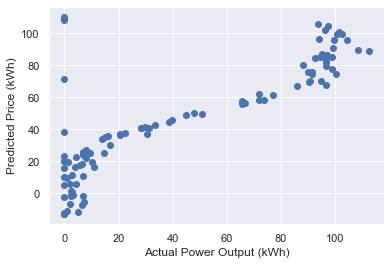

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)


plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Price (kWh)')
plt.show()

If our model had a test RMSE of zero, we would expect every blue dot to land perfectly on the red line. This is not the case of course, and this plot tells us that our model tends to under predict home prices at the lower and higher ends of the price range, while prices in the middle are somewhat equally distributed above and below the perfect fit line.

Overall, our model did a satisfactory job of predicting the median home price, especially for a first effort. Plus, we learned which features are most influential, and which contribute to an increase or decrease in median home price, which can be just as valuable as being able to predict the price itself.

Text(0, 0.5, 'Predicted Price (kWh)')

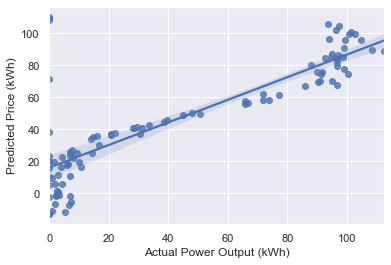

In [18]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Price (kWh)')


### Model Accuracy Versus Interpretability

An important distinction between different supervised learning models,is the general tradeoff between accuracy and interpretability. Interpretability refers to the ability to see how a model arrived at a particular answer, or at a higher level, why the model made the decisions it did. This tradeoff can be viewed in terms of the overall flexibility of a model. Models that are less flexible tend to be less accurate, as they assume a somewhat rigid form of f(x), and can only produce a small range of estimates. Most real world phenomena do not follow such an explicit form, and thus the model will not be able to completely capture the underlying relationship between the features and label. However, because they are somewhat rigid in nature, these models provide a higher level of interpretability. Models that are more flexible tend to more more accurate, as they do not make explicit assumptions about the form of f(x), and can fit a wider variety of shapes to the data. Because they are more flexible, however, they often provide a lower level of interpretability.
 [5]

***

## References
[1] https://www.hindawi.com/journals/jen/2016/8519785/<br>
[2] http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf <br>
[3] https://keras.io/getting_started/intro_to_keras_for_engineers <br>
[4] https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf <br>
[5] https://blogs.oracle.com/datascience/supervised-learning-with-python<br>

### The End